In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from itertools import combinations
from tqdm import tqdm

from params import *
from brian2 import *

# load the data

In [2]:
result_path = 'results/results_tuned1_2.pkl'
with open(result_path, 'rb') as f:
    results = pickle.load(f)

In [3]:
result2_path = 'results/results_tuned1_1.pkl'
with open(result2_path, 'rb') as f:
    results2 = pickle.load(f)

In [4]:
pyrdata = results2['PYR_spike_train']

# Process the data 

In [5]:
pyrdata0=results['PYRDataAll0']
pyrdata1=results['PYRDataAll1']
pyrdata2=results['PYRDataAll2']
pyrdata3=results['PYRDataAll3']

In [6]:
def expand_spike_train(spike_times_raw):
    # transfer the raw data into a list of spike times (unit-free)
    result = []
    for values in spike_times_raw:
        for value in values:
            result.append(value / second)
    return result


In [7]:
def expand_spike_train_2(spike_times_raw):
    # transfer the raw data into a list of spike times (unit-free)
    result = []
    for values in spike_times_raw:
        result.append(values / second)
    return result

In [8]:
def mean_phase_cohearence(spike_times_a, spike_times_b):
    # calculate the mean phase coherence between two spike trains
    mean_sin = 0
    mean_cos = 0
    count = 0
    if len(spike_times_a) == 0 or len(spike_times_b) == 0:
        return 0
    if not(spike_times_a and spike_times_b):
        return None
    for spike_time_a in spike_times_a:
        spike_time_b_2, idx = next(((spike_time_b, idx) for (idx, spike_time_b) in enumerate(spike_times_b) if spike_time_b > spike_time_a), (0, 0))
        if idx == 0:
            continue
        count += 1
        spike_time_b_1 = spike_times_b[idx - 1]
        phase = 2*np.pi*(spike_time_a - spike_time_b_1) / (spike_time_b_2 - spike_time_b_1)
        mean_sin += np.sin(phase)
        mean_cos += np.cos(phase)
        
    if count == 0:
        return 0
    
    mean_sin /= count
    mean_cos /= count
    return (mean_sin**2 + mean_cos**2)**0.5

In [9]:
def calculate_neurons_MPC(neurons_spike_times, N=400):
    results = np.eye(N)
    neuron_pairs = list(combinations(range(N), 2))
    for pair in tqdm(neuron_pairs):
        results[pair] = mean_phase_cohearence(neurons_spike_times[str(pair[0])], neurons_spike_times[str(pair[1])])
        results[pair[::-1]] = results[pair]
    return results

# Analyse the data

In [10]:
plt.rcParams.update({'font.size': 16})

In [11]:
def plot_mpc(mpc):
    tuned_vertical = mpc[np.triu_indices(100, 1)]
    others_vertical = mpc[0:100, 100:].flatten()

    tuned_45 = mpc[(np.triu_indices(100,1)[0]+100, np.triu_indices(100,1)[1]+100)]
    others_45 = np.concatenate((mpc[0:100, 100:200].flatten(), mpc[100:200, 200:].flatten()))
    
    tuned_horizontal = mpc[(np.triu_indices(100,1)[0]+200, np.triu_indices(100,1)[1]+200)]
    others_horizontal = np.concatenate((mpc[0:200, 200:300].flatten(), mpc[200:300, 300:].flatten()))
    
    tuned_135 = tuned_horizontal = mpc[(np.triu_indices(100,1)[0]+300, np.triu_indices(100,1)[1]+300)]
    mask = np.triu(np.ones(400), k=1)
    mask[(np.triu_indices(100,1)[0]+300, np.triu_indices(100,1)[1]+300)] = False
    others_135 = mpc[0:300, 300:400].flatten()
    
    fig = plt.figure(figsize=(23, 14))
    plt.subplot(2,4,1)
    sns.histplot(tuned_vertical, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('| to |')
    plt.subplot(2,4,2)
    sns.histplot(tuned_45, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('/ to /')
    plt.subplot(2,4,3)
    sns.histplot(tuned_horizontal, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('-- to --')
    plt.subplot(2,4,4)
    sns.histplot(tuned_135, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('\\ to \\')
    plt.subplot(2,4,5)
    sns.histplot(others_vertical, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('| to others')
    plt.subplot(2,4,6)
    sns.histplot(others_45, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('/ to others')
    plt.subplot(2,4,7)
    sns.histplot(others_horizontal, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('-- to others')
    plt.subplot(2,4,8)
    sns.histplot(others_135, bins=20, binrange=(0, 1), stat='probability')
    plt.ylim(0, 0.5)
    plt.title('\\ to others')
    return np.mean(tuned_vertical), np.mean(others_vertical), np.mean(tuned_45), np.mean(others_45), np.mean(tuned_horizontal), np.mean(others_horizontal), np.mean(tuned_135), np.mean(others_135)

In [12]:
def analyse(neurons_spike_times):
    before_time = params['nonplasticwarmup_simtime'] / second
    after_time = (params['nonplasticwarmup_simtime'] + params['warmup_simtime'] + params['reward_simtime'] + params['noreward_simtime'] + params['noSSTPV_simtime']) / second
    neurons_spike_times_before = {key: [spike_time for spike_time in spike_times if spike_time <= before_time] for key, spike_times in neurons_spike_times.items()}
    neurons_spike_times_after = {key: [spike_time for spike_time in spike_times if spike_time >= after_time] for key, spike_times in neurons_spike_times.items()}
    mpc_before = calculate_neurons_MPC(neurons_spike_times_before)
    mpc_after = calculate_neurons_MPC(neurons_spike_times_after)
    mean_mpcs_before = plot_mpc(mpc_before)
    print('mean_mpcs_before\n', mean_mpcs_before)
    mean_mpcs_after = plot_mpc(mpc_after)
    print('mean_mpcs_after\n', mean_mpcs_after)
    fig = plt.figure(figsize=(18, 7))
    plt.subplot(1,2,1)
    sns.heatmap(mpc_before, cmap='RdBu_r', vmin=0, vmax=1).set_title("MPC before training")
    plt.xticks([0,100,200,300], ['|', '/', '--', '\\'])
    plt.xticks(rotation=0)
    plt.yticks([0,100,200,300], ['|', '/', '--', '\\'])
    plt.subplot(1,2,2)
    sns.heatmap(mpc_after, cmap='RdBu_r', vmin=0, vmax=1).set_title("MPC After training")
    plt.xticks([0,100,200,300], ['|', '/', '--', '\\'])
    plt.xticks(rotation=0)
    plt.yticks([0,100,200,300], ['|', '/', '--', '\\'])

100%|██████████| 79800/79800 [00:07<00:00, 10201.14it/s]


mean_mpcs_before
 (0.37175539059232504, 0.1642903965925419, 0.5075856184808719, 0.4061750757623294, 0.5120254972194951, 0.40244425280864315, 0.5120254972194951, 0.3978050100463501)
mean_mpcs_after
 (0.7024736003402956, 0.18923461080085083, 0.012527299494754509, 0.1701531396964683, 0.6016152149016722, 0.3278992800226793, 0.6016152149016722, 0.4119027552648754)


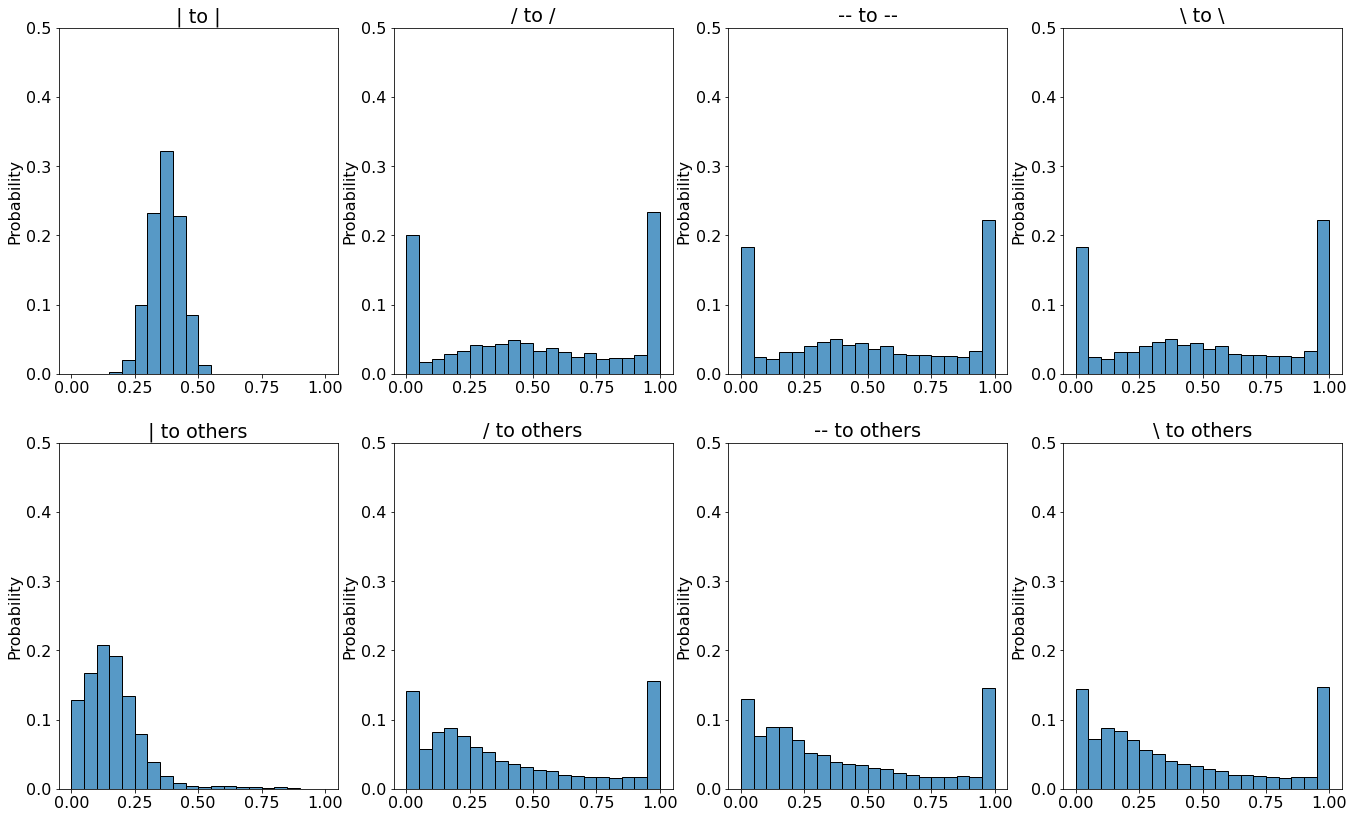

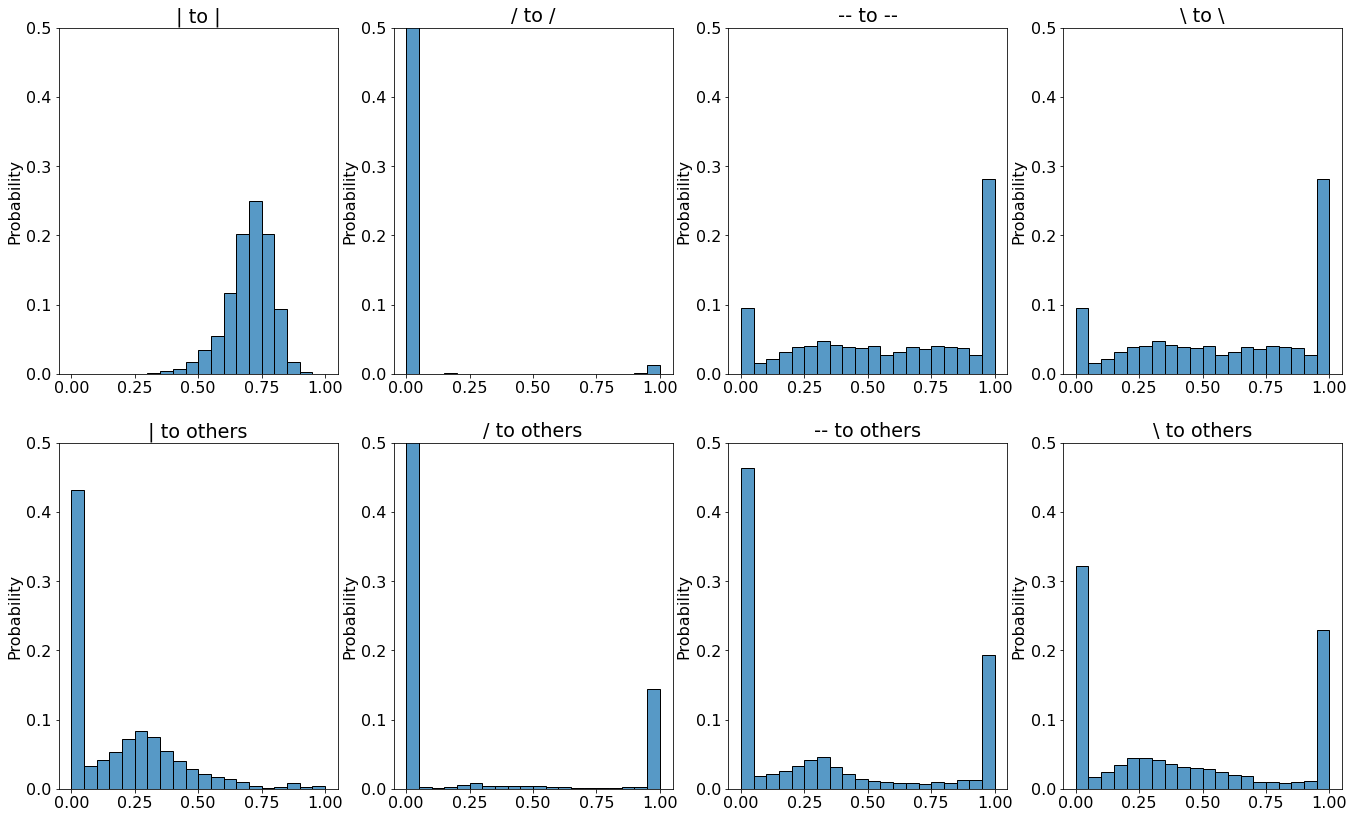

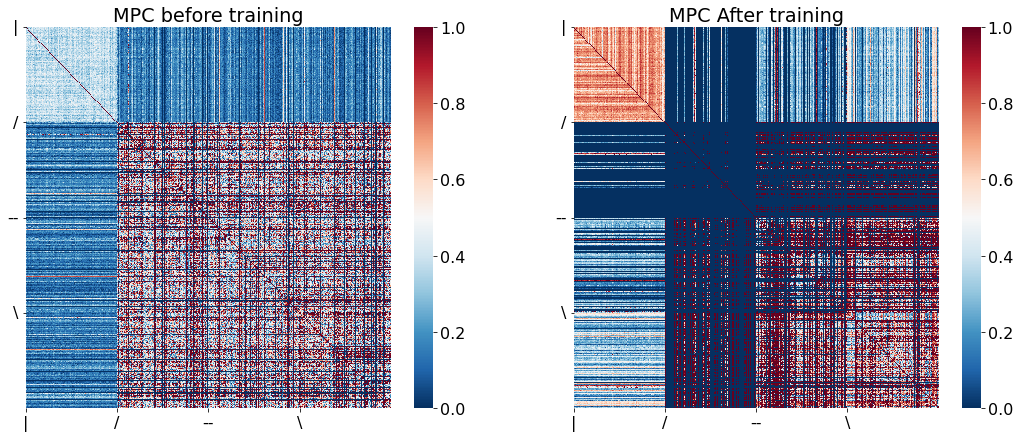

In [13]:
neurons_spike_times = {key: expand_spike_train(value) for key, value in pyrdata0.items()}
analyse(neurons_spike_times)

100%|██████████| 79800/79800 [00:30<00:00, 2622.33it/s]


mean_mpcs_before
 (0.5269746656534462, 0.5965671742485552, 0.40604974961260054, 0.3914443240209707, 0.47654069238410784, 0.39978865456453994, 0.47654069238410784, 0.4081591063616978)
mean_mpcs_after
 (0.8848365125509471, 0.7788367188840325, 0.760721159085288, 0.765198220870842, 0.7823143643375136, 0.7349201535071919, 0.7823143643375136, 0.7791163299162246)


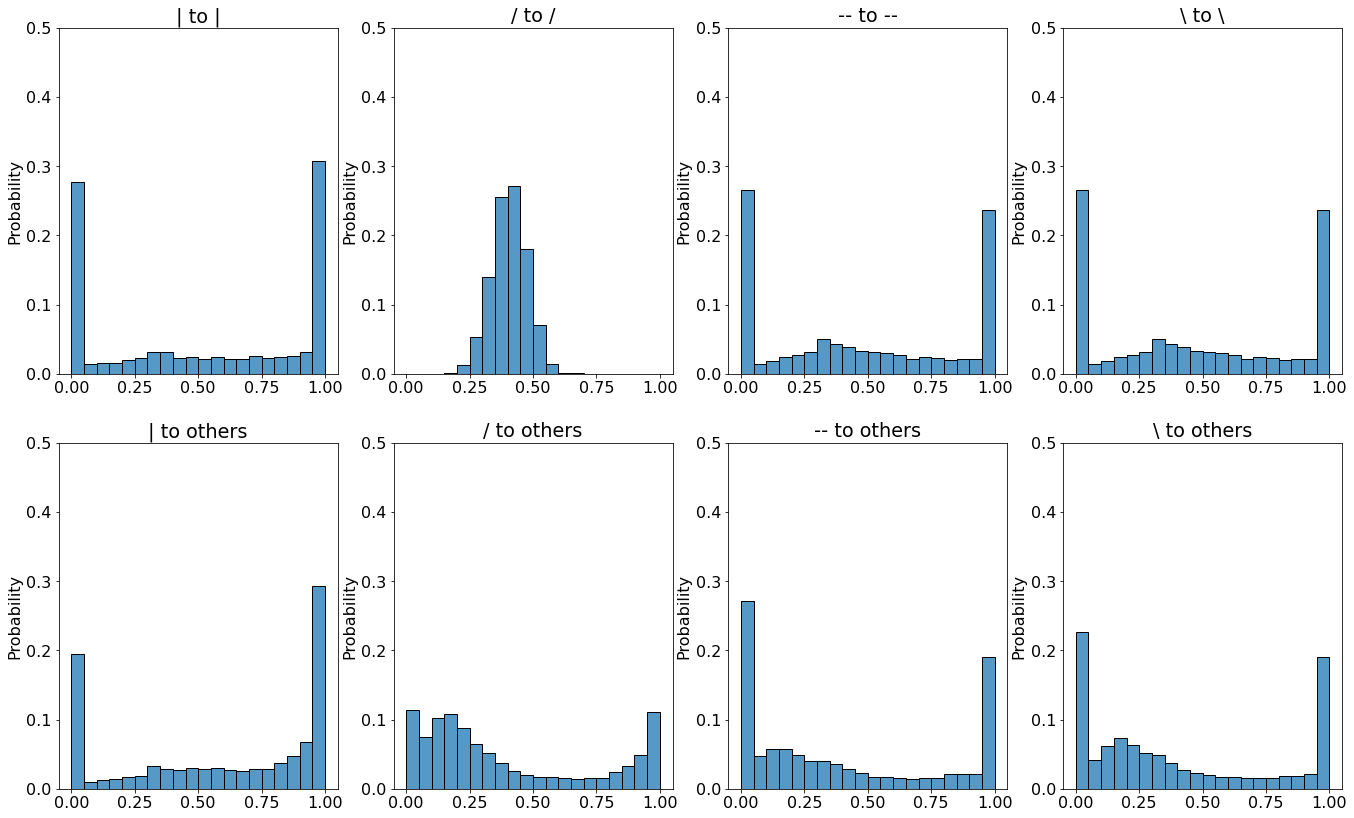

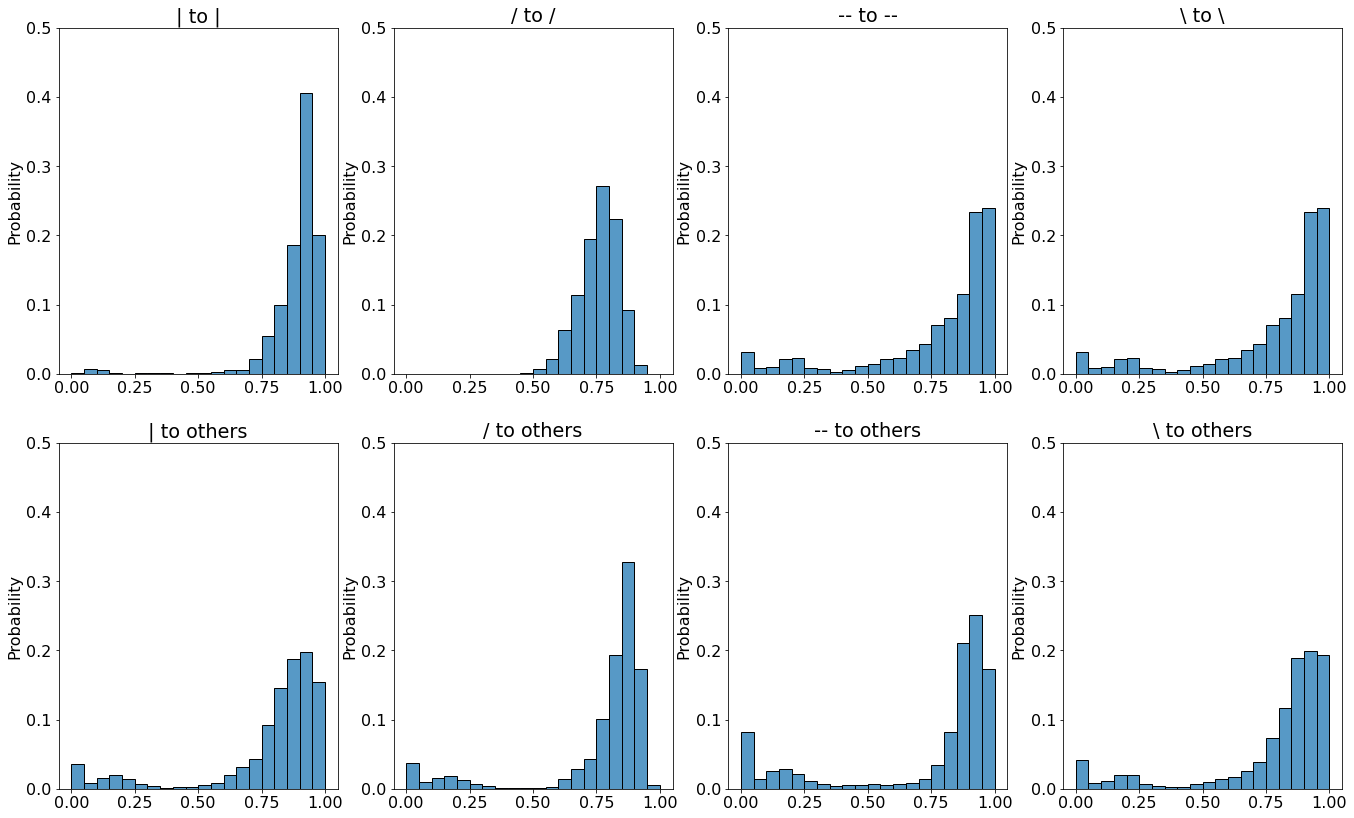

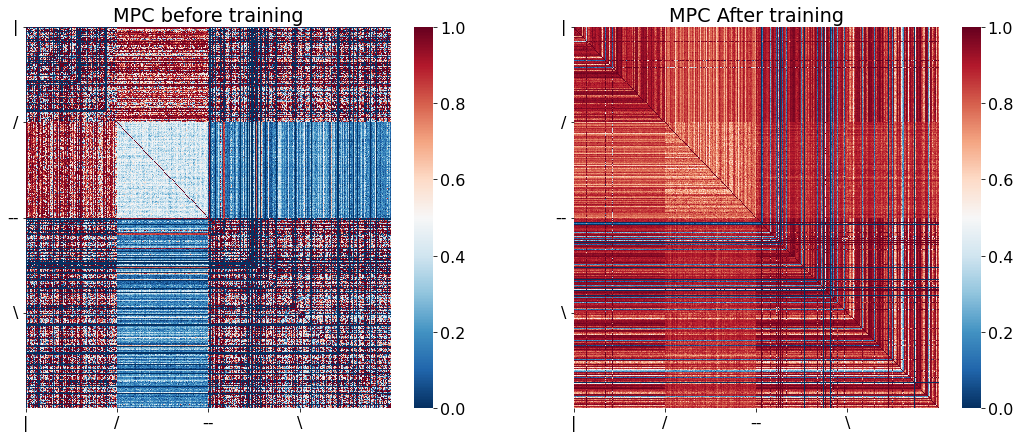

In [14]:
neurons_spike_times = {key: expand_spike_train(value) for key, value in pyrdata1.items()}
analyse(neurons_spike_times)

100%|██████████| 79800/79800 [00:06<00:00, 11945.37it/s]


mean_mpcs_before
 (0.512442725925969, 0.5628556793128198, 0.530781740125788, 0.5647348162849779, 0.4929291855756339, 0.5339652550008114, 0.4929291855756339, 0.3657634289887646)
mean_mpcs_after
 (0.49980930954261, 0.47080072150130353, 0.030241031328166294, 0.3021089244756908, 0.5467179417905745, 0.5230064866068652, 0.5467179417905745, 0.4311385894289934)


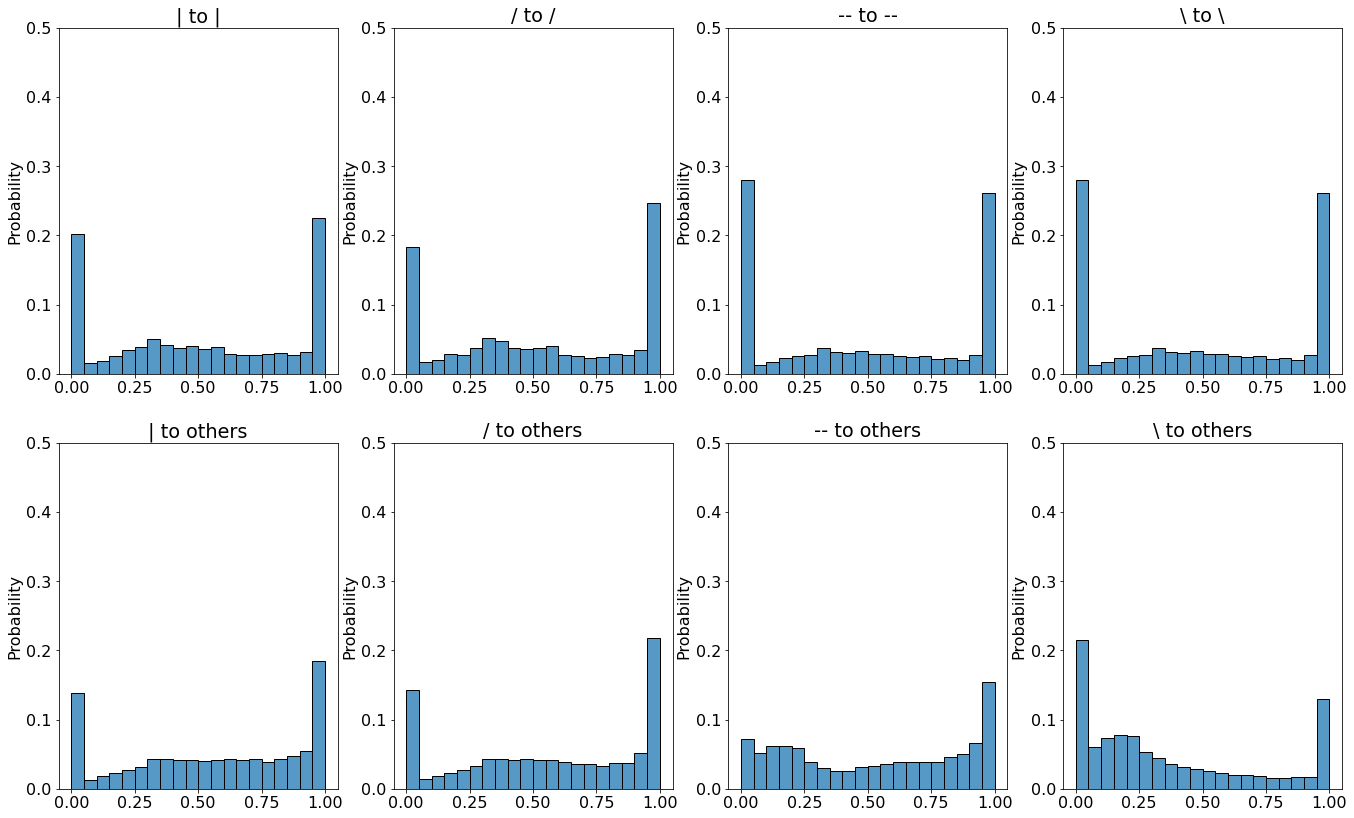

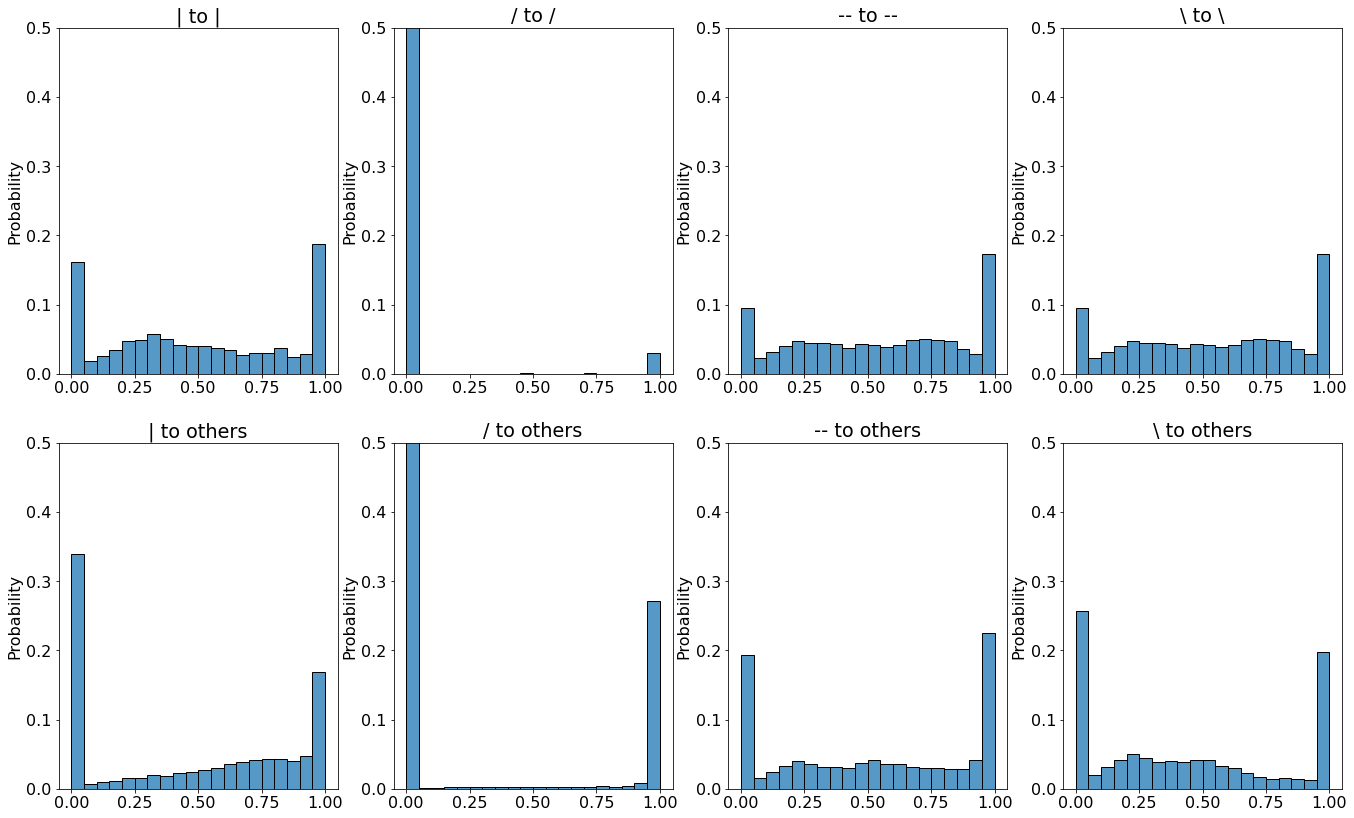

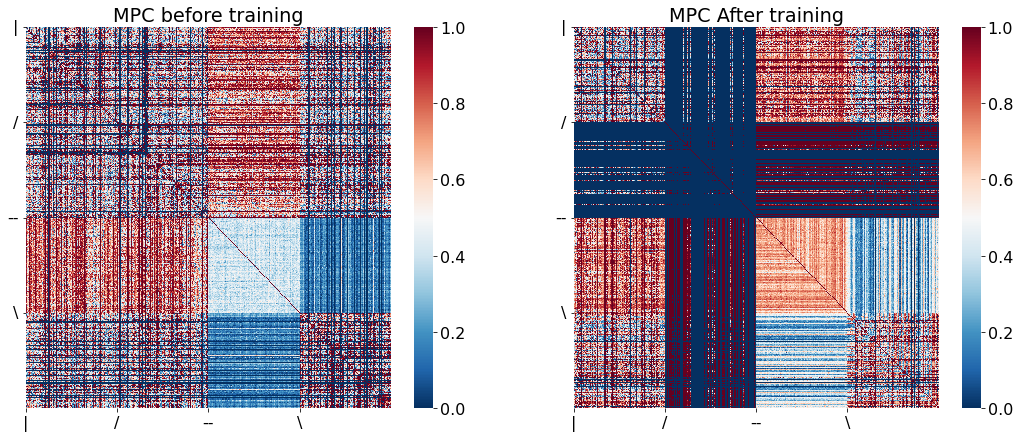

In [15]:
neurons_spike_times = {key: expand_spike_train(value) for key, value in pyrdata2.items()}
analyse(neurons_spike_times)

100%|██████████| 79800/79800 [00:04<00:00, 17297.77it/s]


mean_mpcs_before
 (0.4835558429250949, 0.5757860559604248, 0.5853561087124728, 0.5907791186287141, 0.38743521661918023, 0.5754683217188724, 0.38743521661918023, 0.6925876274465369)
mean_mpcs_after
 (0.526123202389724, 0.4199406053214961, 0.03163482978384461, 0.3011791469272244, 0.6114323084618374, 0.4849425646425448, 0.6114323084618374, 0.6589310400987967)


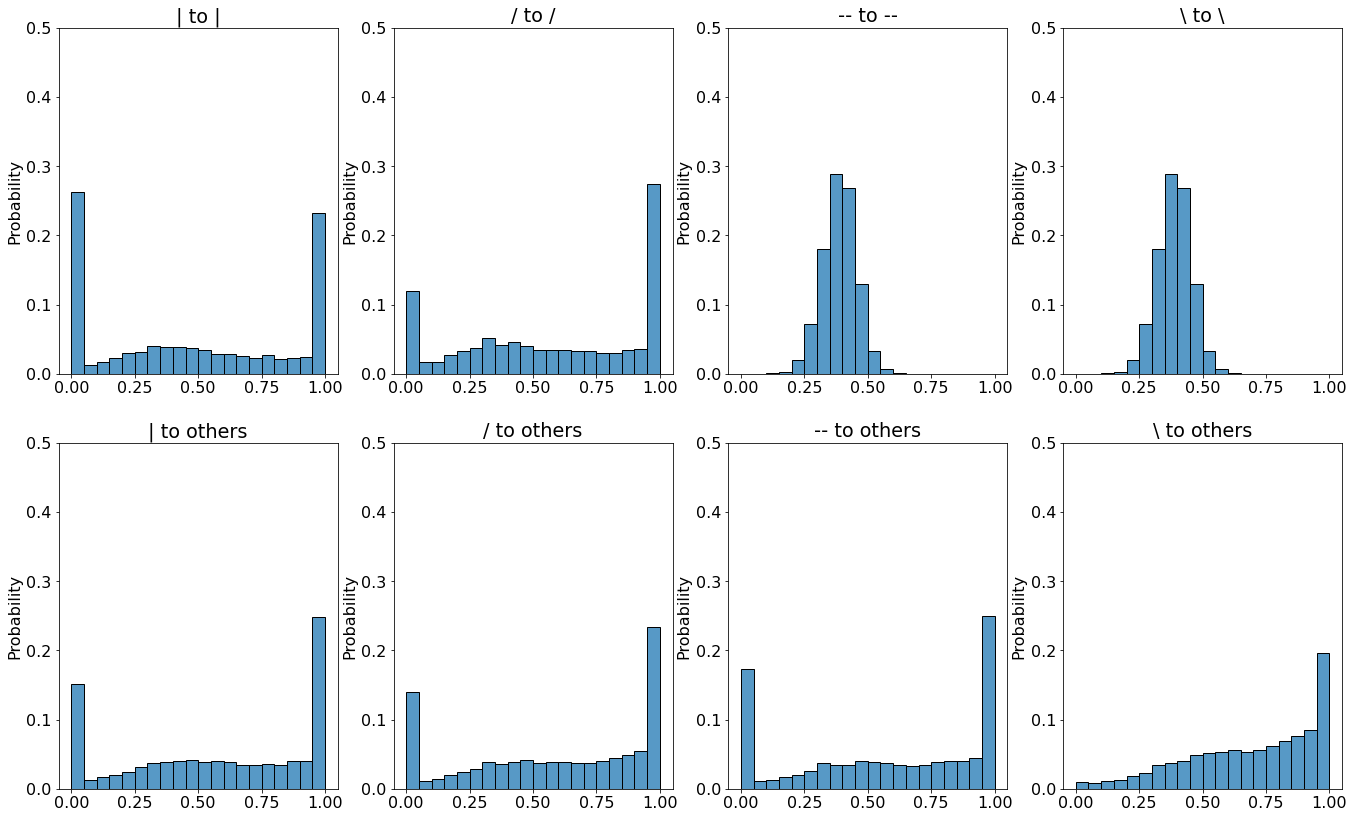

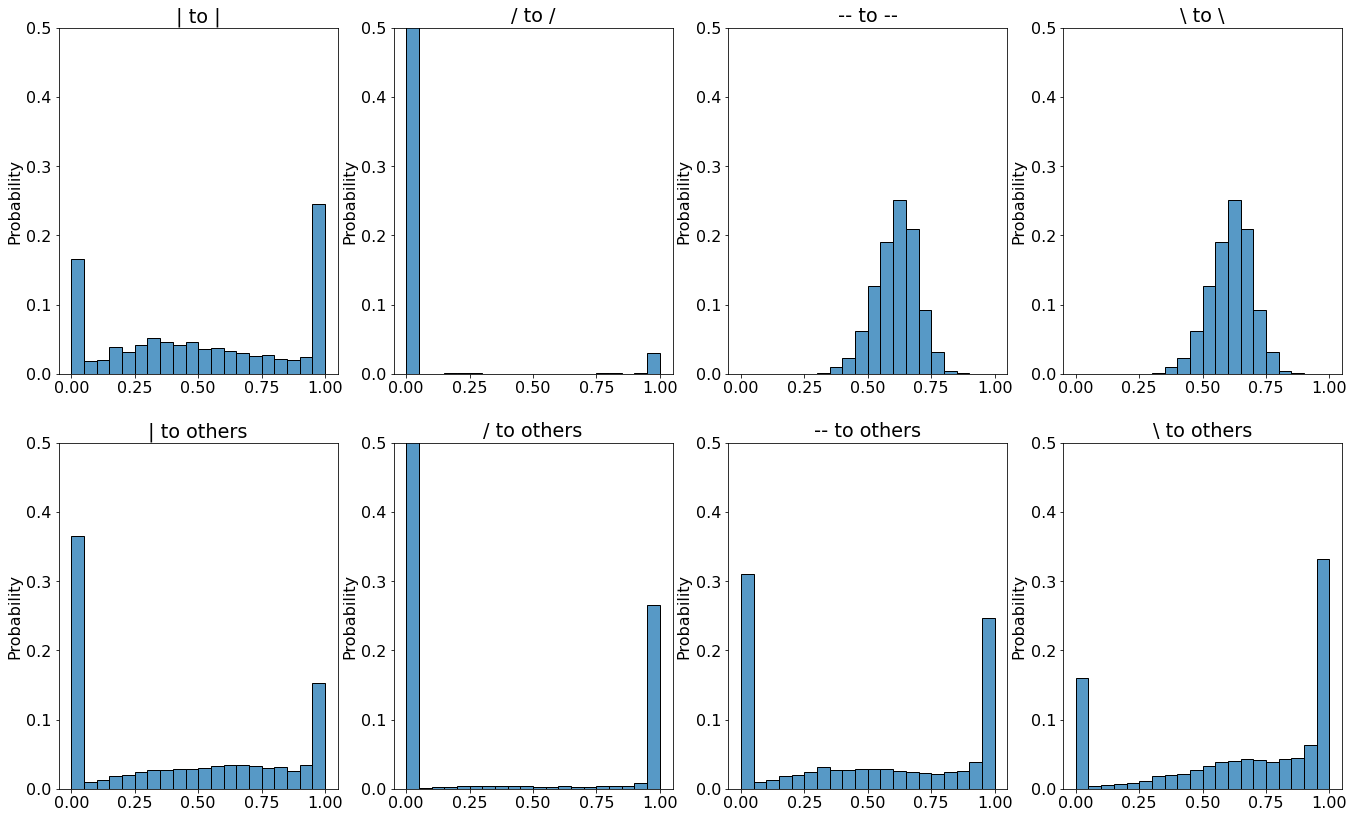

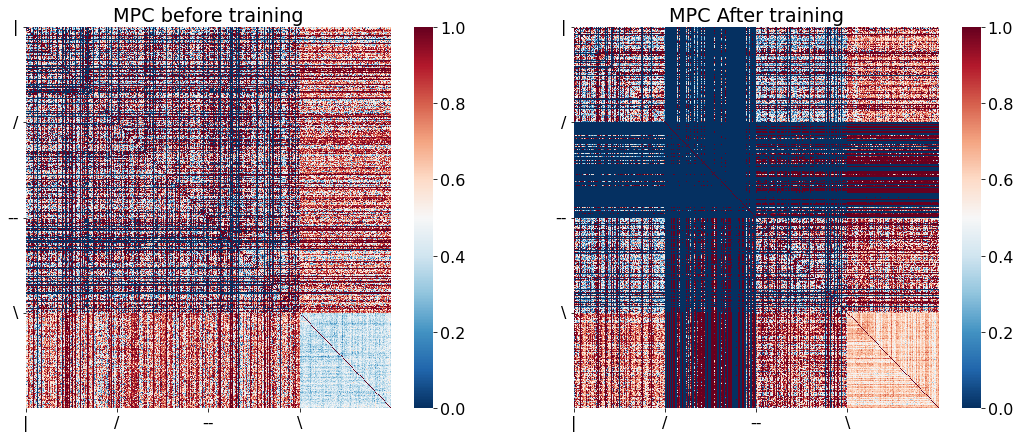

In [16]:
neurons_spike_times = {key: expand_spike_train(value) for key, value in pyrdata3.items()}
analyse(neurons_spike_times)

100%|██████████| 79800/79800 [01:18<00:00, 1018.63it/s]


mean_mpcs_before
 (0.3233179492182053, 0.1148124625184692, 0.3377377063724599, 0.12908943796768874, 0.33435010583638625, 0.1311033626950572, 0.33435010583638625, 0.13045970054594838)
mean_mpcs_after
 (0.6663824698160002, 0.27635108013168685, 0.7232087079238949, 0.5569608923200423, 0.5464529163844712, 0.4016863834887976, 0.5464529163844712, 0.44590170352463004)


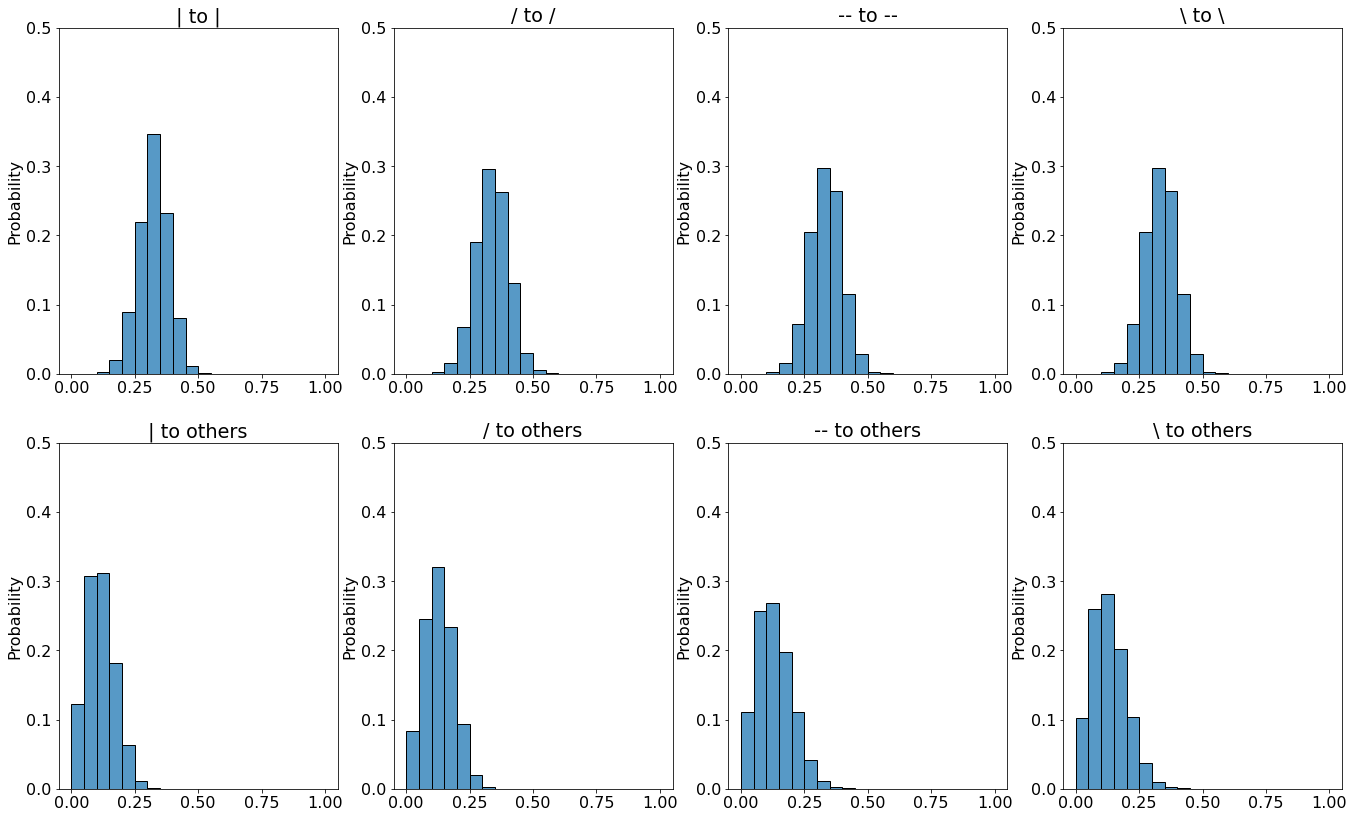

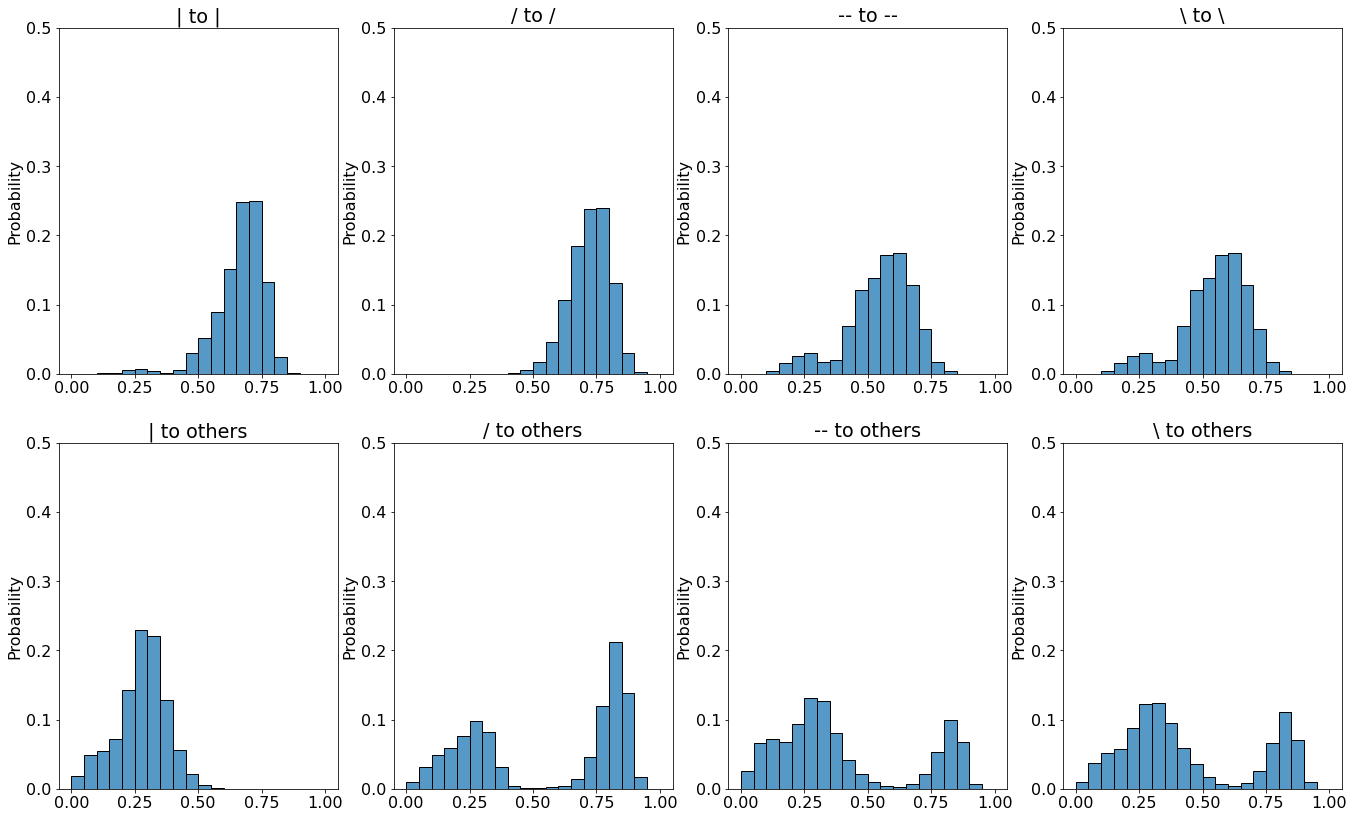

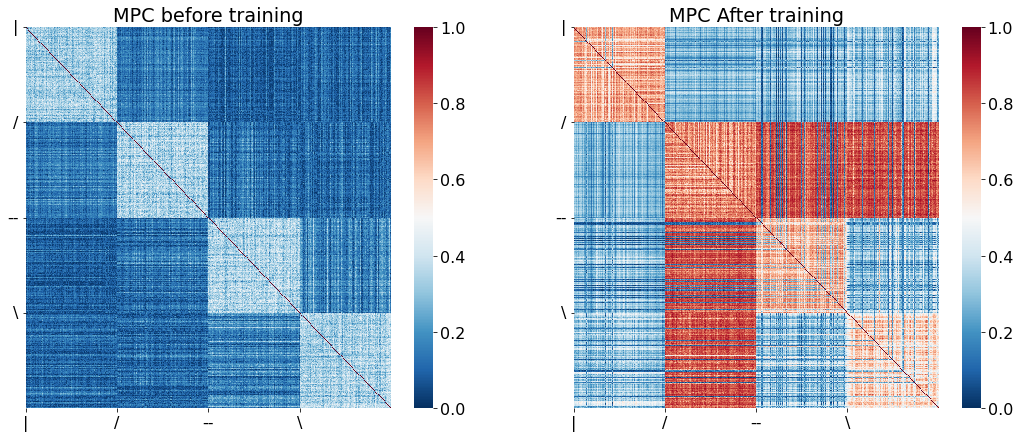

In [17]:
neurons_spike_times = {str(key): expand_spike_train_2(value) for key, value in pyrdata.items()}
analyse(neurons_spike_times)